<a href="https://colab.research.google.com/github/Luis-Menezes/CI-Chemistry/blob/main/HandsOn_DataClustering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Chemistry - Hands on Data Clustering Molecules
### Luis Filipe C. de Menezes - RA: 164924
This is part of an assignment for the Computational Intelligence in Chemistry course on UNIFESP's masters program.

This notebook must use data from QM9 to do the following:

I. Extract any simple descriptors from the SMILES
representation, e.g.,

- Physical/Chemical descriptors (molecular mass,
etc.), RDKit descriptors, Mordred, etc. (do not
consider geometry for this task)

II. Using the feature vector, perform data
clustering with at leas two algorithms (select
algorithms with distinct approaches)

- E.g., K-Means and DBScan

III. Use one internal and one external measure to
evaluate the clusters
- Internal: Silhouette
- External: any property

IV. Evaluate the clustering for several parameters
(K, Epsilon, minPts, etc.)

## Needed packages

In [1]:
!pip install --quiet rdkit
!pip install --quiet mordred

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem

## Load and unpack QM9 dataset

## Open XYZ files and extract the properties and SMILES

In [3]:
qm9_folder = 'qm9_files/'
QM9_PROPERTIES = [
    "A", 'B', 'C', 'mu', 'alpha',
    'homo', 'lumo', 'gap', 'r2',
    'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]

with open(qm9_folder+'dsgdb9nsd_113885.xyz') as file:
  for line in file:
    print(line)

19

gdb 113885	3.70802	0.80999	0.7081	2.6975	73.65	-0.2639	0.0141	0.278	1593.5236	0.156316	-460.174889	-460.164623	-460.163679	-460.212278	35.326	

C	-0.008898706	 1.435343511	-0.1229342875	-0.480889

C	-0.097211668	-0.0611740136	 0.0533750899	 0.431334

O	-0.522805097	-0.6329577977	 1.0223608396	-0.34442

O	 0.3874153201	-0.692641184	-1.0454419183	-0.247509

C	 0.3502508225	-2.1099666389	-1.0216443391	 0.118249

C	-0.6452778548	-2.8049992501	-1.9010293635	-0.305338

C	 0.8299955957	-2.806393386	-2.257736521	-0.04378

C	 1.3090797685	-2.0281448361	-3.4552388748	-0.093611

O	 1.0953742585	-2.8320000843	-4.6085691448	-0.419869

H	-0.3728027153	 1.9278328937	 0.7777832851	 0.149542

H	 1.0248947898	 1.7315350968	-0.3210999853	 0.149596

H	-0.6070917791	 1.7459702376	-0.9844780335	 0.149165

H	 0.576972916	-2.5190329042	-0.0453019279	 0.12476

H	-1.1102986284	-3.7153217605	-1.5406769745	 0.122235

H	-1.2860640388	-2.1730656326	-2.5065209428	 0.123942

H	 1.3703384329	-3.7344941519	-2.09474

### I. Extracting physical descriptors
Using Mordred and RDKit to extract descriptors.

**Mordred** is a high-performance Python package for calculating over 1,800 2D and 3D molecular descriptors. These descriptors serve as numerical features representing a molecule's structure, which are essential for developing machine learning models like QSPR and QSAR. Built on RDKit, it's designed for speed and can be used as a command-line tool or directly within a Python script, offering flexibility for data processing pipelines.

Could have used the function numHDonors and numHAcceptors but wanted to see how Mordred works.

Quick description of used descriptors:
- **BasicGroupCount**: counts how many basic groups (H+ receivers) are in the molecule.
- **AcidicGroupCount**: counts how many acidic groups (H+ donators) are in the molecule.
- **Chi0**: molecular descriptor that represents the zero-order atomic connectivity index of a molecule.
- **MolLogP**:
- **RingCount**: counts how many rings are in the molecule.







In [4]:
from mordred import AcidBase
from rdkit import Chem
from rdkit.Chem.Descriptors import Chi0, MolLogP, MolWt, RingCount, TPSA, FractionCSP3, Phi

def calculate_descriptors(molecule):
  base_gc = AcidBase.BasicGroupCount()
  acid_gc = AcidBase.AcidicGroupCount()
  chi = Chi0(molecule)
  logp = MolLogP(molecule)
  mw = MolWt(molecule)
  ring_count = RingCount(molecule)
  tpsa = TPSA(molecule)
  csp3 = FractionCSP3(molecule)
  phi = Phi(molecule)

  return {str(base_gc): base_gc(molecule),
          str(acid_gc): acid_gc(molecule),
          "RingCount": ring_count,
          "Chi0": chi,
          "MolLogP": logp,
          "MolWt": mw,
          "TPSA": tpsa,
          "Fraction CSP3": csp3,
          "Phi": phi}


if __name__ == '__main__':
  with open(qm9_folder+'dsgdb9nsd_113885.xyz', 'r') as file:
      lines = file.readlines()
      print("Test Smiles:", lines[22].split()[0])
      mol = Chem.MolFromSmiles(lines[22].split()[0])
      print(calculate_descriptors(mol))

Test Smiles: CC(=O)OC1CC1CO
{'nBase': 0, 'nAcid': 0, 'RingCount': 1, 'Chi0': np.float64(6.8533711511285205), 'MolLogP': -0.06970000000000004, 'MolWt': 130.143, 'TPSA': 46.53, 'Fraction CSP3': 0.8333333333333334, 'Phi': 1.7109047903148478}


In [6]:
def load_validate_mol(file):
  with open(file, 'r') as file:
    n_atoms = int(file.readline())

    properties_list = file.readline().split()
    mol_id = properties_list[1]
    properties_values = [float(prop) for prop in properties_list[2:]]

    atoms = []
    for nlines in range(n_atoms):
      atom = file.readline().split()
      atoms.append(atom[0]) # get only the the atom string

      # Since we doesn't need coordinates for this assignment, we will ignore it for now
      # atom_coords = atom[1:3]
      # atom_coords = [float(coord) for coord in atom_coords]
      # print(atom)
    # print(atoms)
    file.readline() # ignores the frequencies

    smiles_list = file.readline().split()
    properties_dict = dict(zip(QM9_PROPERTIES, properties_values))


    mol = Chem.MolFromSmiles(smiles_list[0]) # If it's None then smiles is invalid
    if mol is None:
        print("Invalid smiles for arquive: ", mol_id)
        return
    canon_smiles = Chem.CanonSmiles(smiles_list[0])
    descriptors = calculate_descriptors(mol)
    properties_dict.update(descriptors)

    molecule_data = {
                'id': mol_id,
                'n_atoms': n_atoms,
                'atom_list': atoms,
                'smiles': canon_smiles
            }
            # Adiciona as 12 propriedades ao dicionário principal
    molecule_data.update(properties_dict)
    return molecule_data


def get_full_dataset(folder):
  dataset_list = []
  # print(f"Lendo arquivos da pasta: {folder}")

  files_to_process = [f for f in os.listdir(folder) if f.endswith('.xyz')]
  for i, file in enumerate(files_to_process):

      if (i + 1) % 10000 == 0:
          print(f"  Processando arquivo {i+1}/{len(files_to_process)}...")

      file_path = os.path.join(folder, file)

      # Chama a função de processamento para um arquivo
      molecule_data = load_validate_mol(file_path)

      # Se a função retornou dados válidos (não None), adiciona à lista
      if molecule_data:
          dataset_list.append(molecule_data)

      else:
        print("Couldn't proccess file:", file_path)
  return dataset_list




if __name__ == '__main__':
  full_dataset = get_full_dataset(qm9_folder)

  df = pd.DataFrame(full_dataset)
  # load_validate_mol(qm9_folder+'dsgdb9nsd_113885.xyz')

  Processando arquivo 10000/133885...
  Processando arquivo 20000/133885...
  Processando arquivo 30000/133885...
  Processando arquivo 40000/133885...
  Processando arquivo 50000/133885...
  Processando arquivo 60000/133885...
  Processando arquivo 70000/133885...
  Processando arquivo 80000/133885...
  Processando arquivo 90000/133885...
  Processando arquivo 100000/133885...
  Processando arquivo 110000/133885...
  Processando arquivo 120000/133885...
  Processando arquivo 130000/133885...


In [7]:
df.head()

id  n_atoms                                          atom_list  \
0  24741       12               [O, C, C, C, C, N, C, C, O, H, H, H]   
1  59013       18  [C, C, O, C, C, N, C, O, C, H, H, H, H, H, H, ...   
2  42891       17  [N, C, N, C, C, C, C, C, O, H, H, H, H, H, H, ...   
3  94738       19  [C, C, O, C, C, O, C, O, C, H, H, H, H, H, H, ...   
4  34702       15      [N, C, C, C, C, C, C, C, N, H, H, H, H, H, H]   

               smiles        A        B        C      mu  alpha    homo  ...  \
0     C#CC(=O)c1ncco1  3.82396  1.27192  0.95445  2.8364  72.43 -0.2671  ...   
1   CC(O)C1=CNC(=O)C1  3.61630  0.95013  0.88882  4.2815  75.84 -0.2121  ...   
2    N=C1N2CC2C12CCO2  2.92914  1.57965  1.28871  3.2970  73.68 -0.2413  ...   
3     CC1OCC2(O)COC12  2.74888  1.55133  1.26997  2.0216  70.81 -0.2498  ...   
4  N#CC1C2C3C1N1C2C31  5.18897  1.33325  1.31918  3.3817  71.48 -0.2512  ...   

       Cv  nBase  nAcid  RingCount      Chi0  MolLogP    MolWt   TPSA  \
0  26.421      0      0          1  6.690234  0.49050  121.095  43.10   
1  33.758      0      0          1  6.853371 -0.22900  127.143  49.33   
2  28.931      2      0          3  6.060478 -0.17943  124.143  36.09   
3  32.230      0      0          2  6.483128 -0.46500  130.143  38.69   
4  24.793      1      0          4  5.748559 -0.17922  118.139  26.80   

   Fraction CSP3       Phi  
0       0.000000  1.324634  
1       0.500000  1.529526  
2       0.833333  0.429887  
3       1.000000  0.928349  
4       0.857143  0.267755  

[5 rows x 28 columns]

Saves QM9 into the csv dataset to fasten loading

In [8]:
df.to_csv('datasets_csv/full_qm9.csv', index=False)

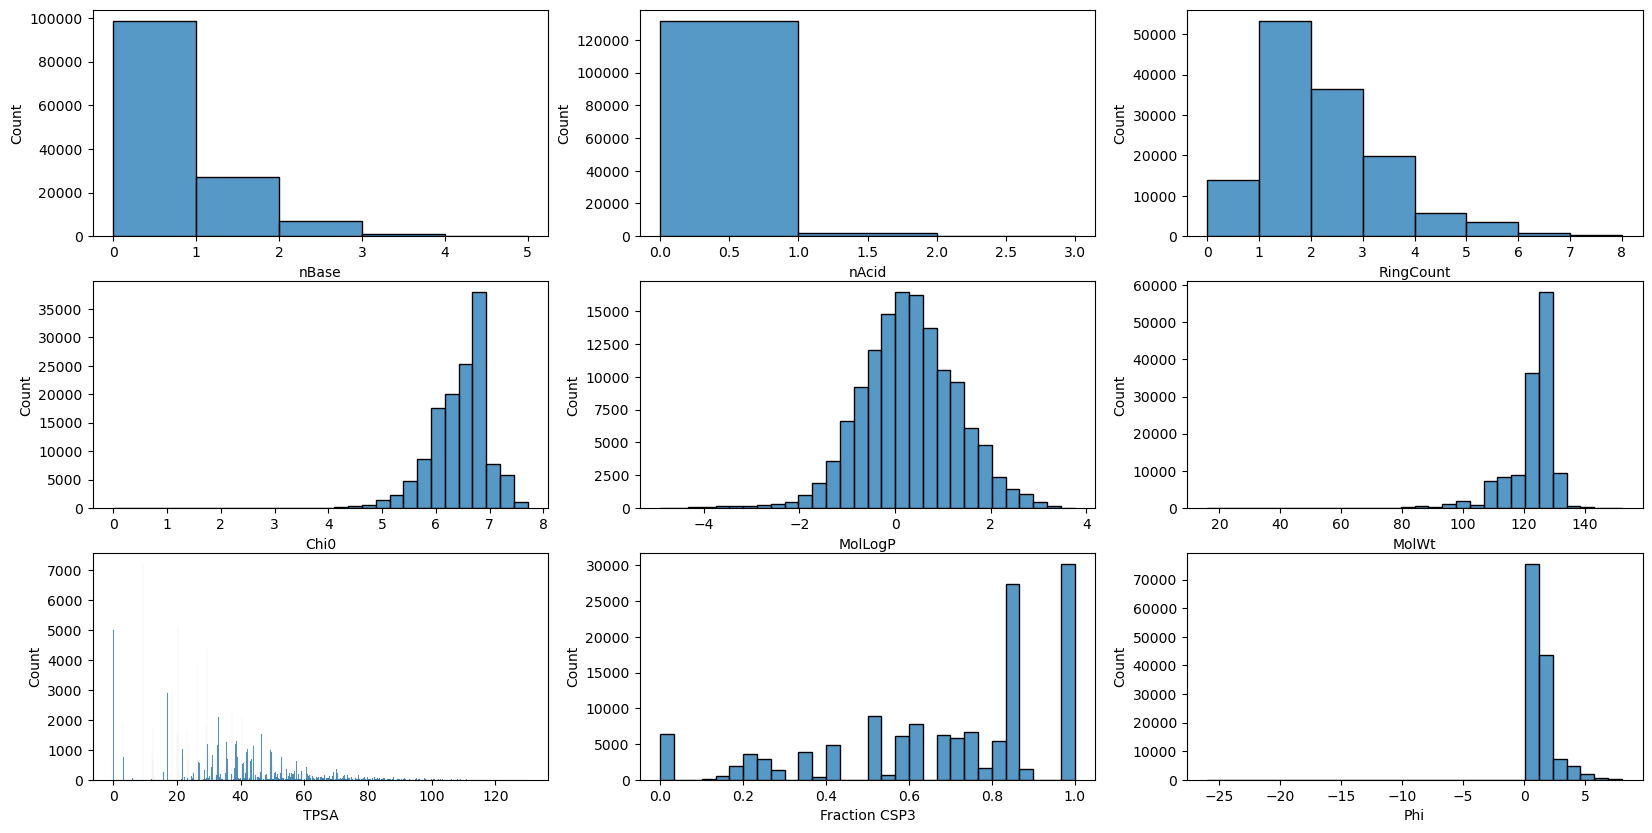

In [9]:
import math
axis, fig = plt.subplots(3, 3, figsize=(20, 10))
sns.histplot(df['nBase'], binwidth=1, ax=fig[0][0])
sns.histplot(df['nAcid'], binwidth=1, ax=fig[0][1])
sns.histplot(df['RingCount'], binwidth=1, ax=fig[0][2])
sns.histplot(df['Chi0'], bins=30, ax=fig[1][0])
sns.histplot(df['MolLogP'], bins=30, ax=fig[1][1])
sns.histplot(df['MolWt'], bins=30, ax=fig[1][2])
sns.histplot(df['TPSA'], binwidth=0.1, ax=fig[2][0])
sns.histplot(df['Fraction CSP3'], bins=30, ax=fig[2][1])
sns.histplot(df['Phi'], bins=30, ax=fig[2][2])
plt.show()

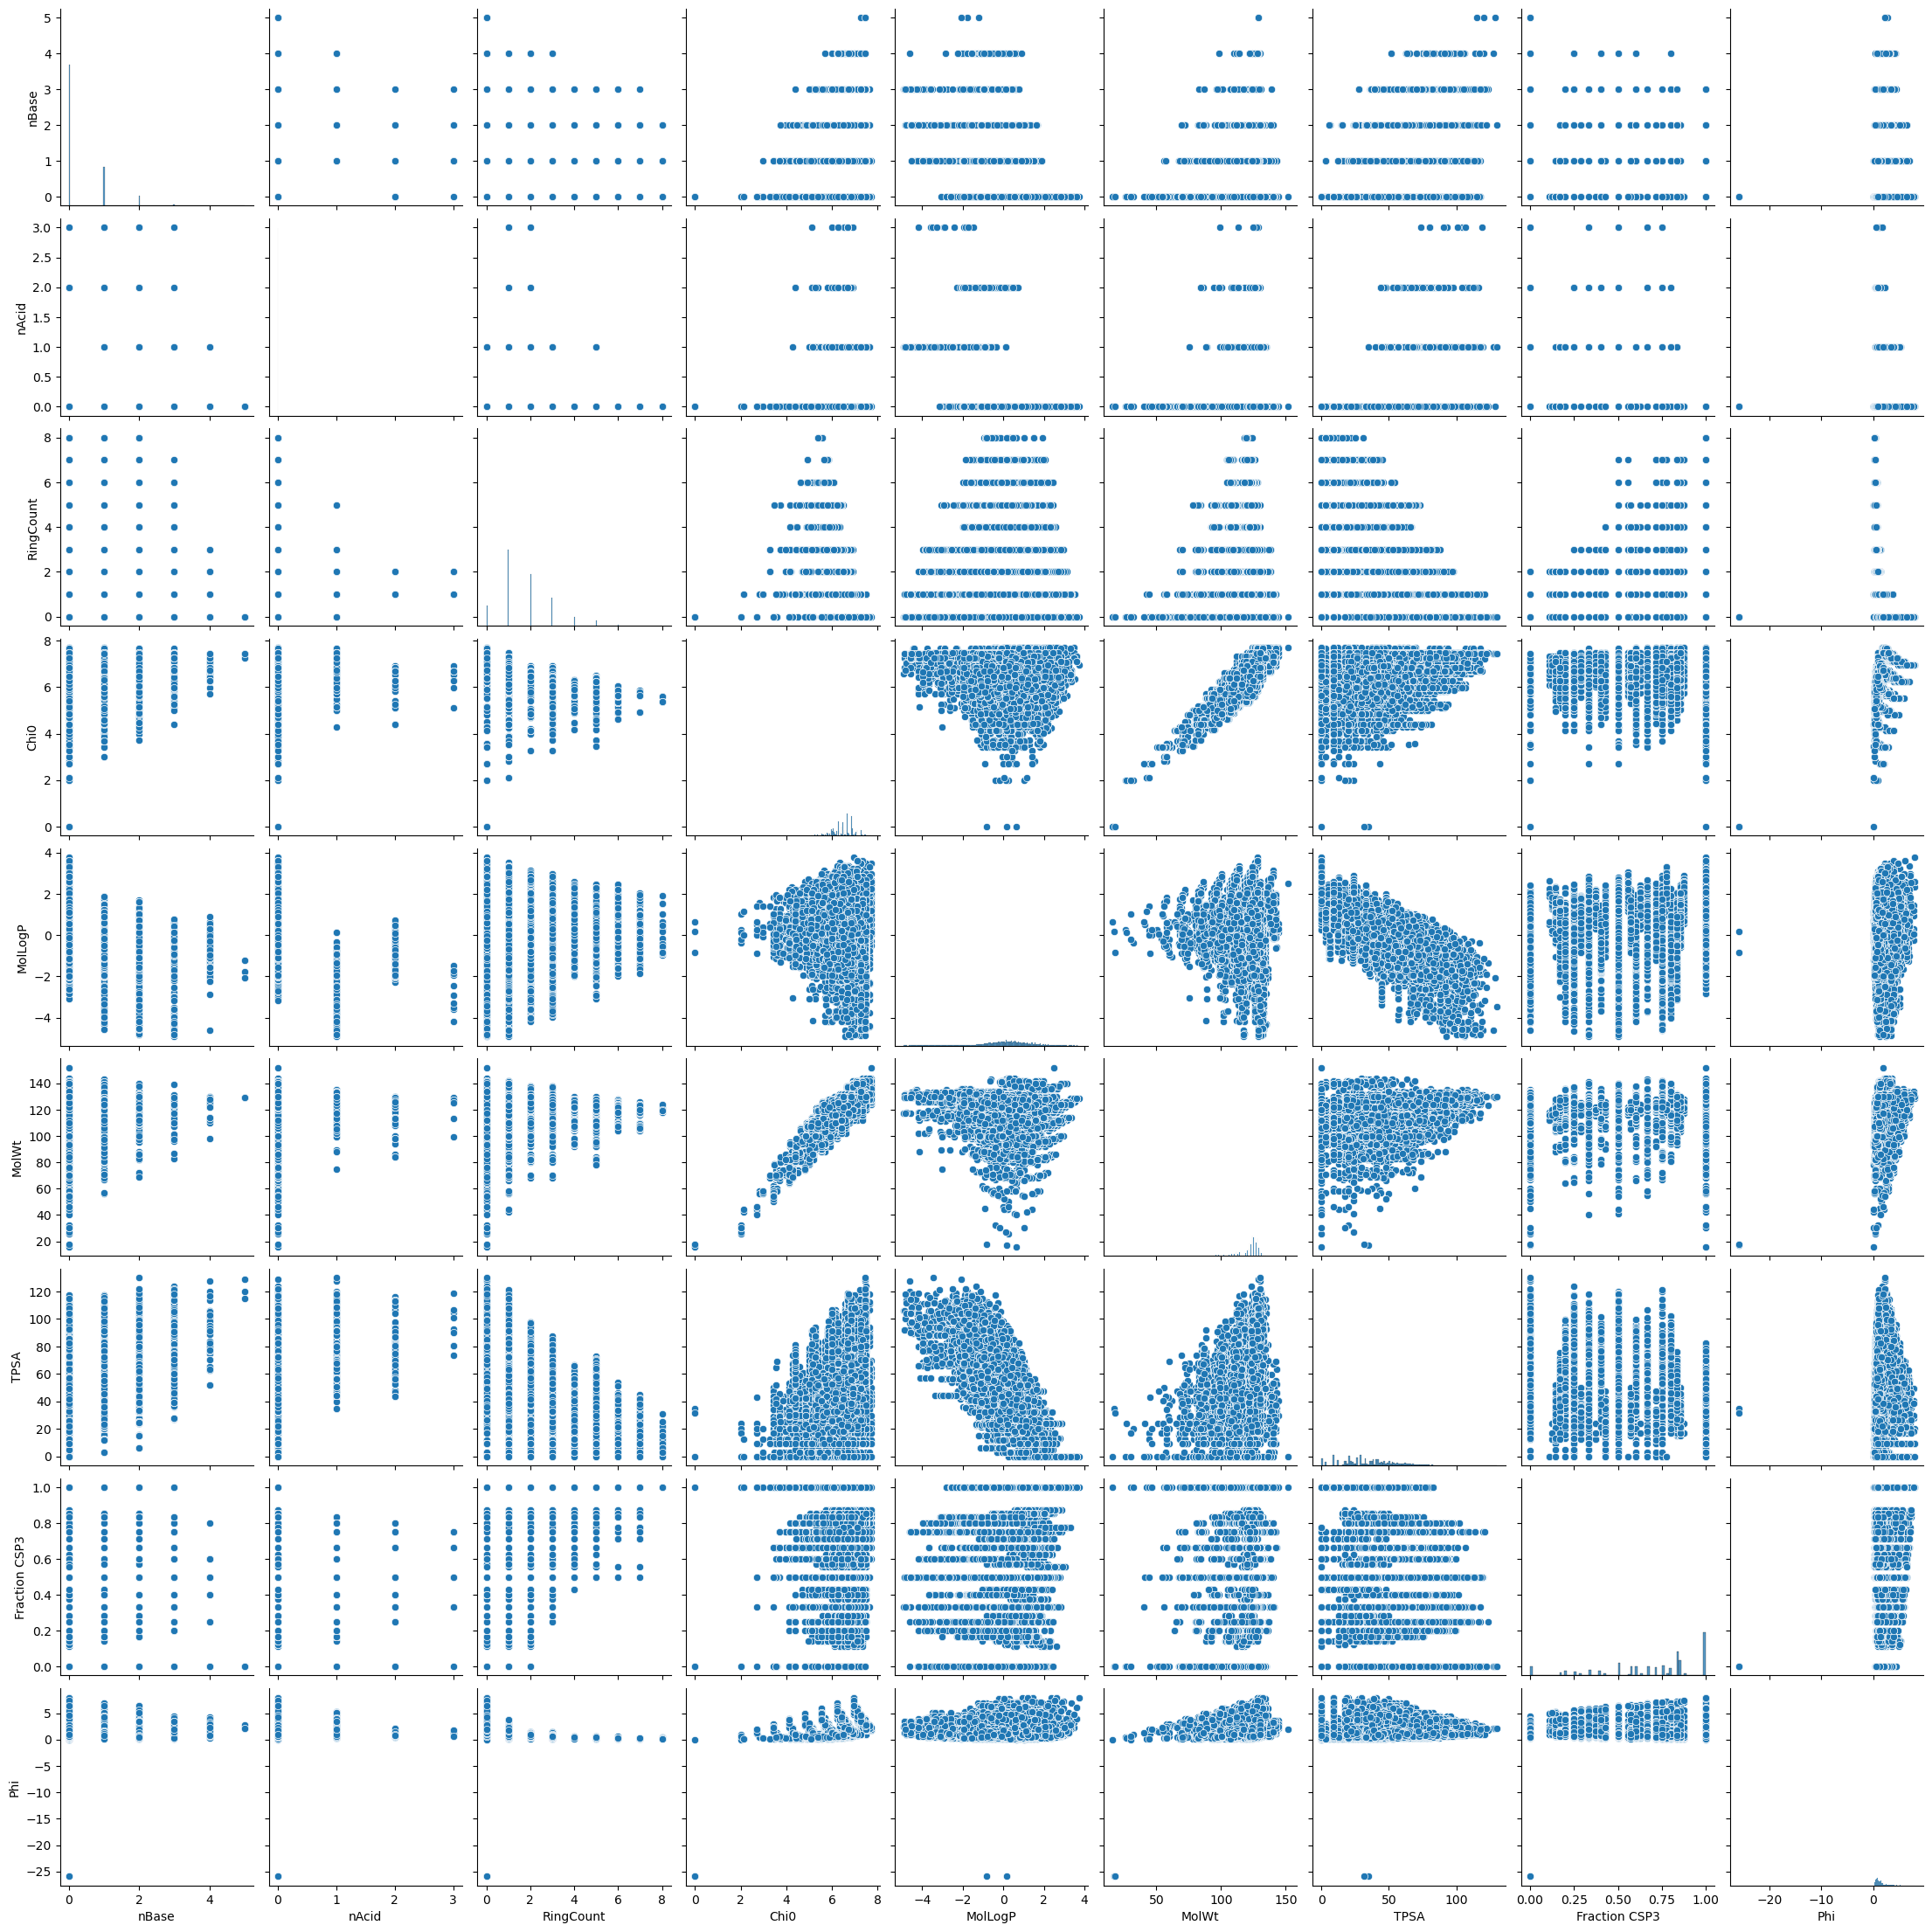

In [10]:
descriptors_list = ['nBase', 'nAcid', 'RingCount', 'Chi0', 'MolLogP', 'MolWt', 'TPSA', 'Fraction CSP3', 'Phi']


sns.pairplot(df[descriptors_list])
plt.show()

### II. Use the feature vectors for 2 clusterization algorithms

Thinking of using the **K-means algorithm** and **optics**.
First we have to normalize the feature vector.

#### Normalizing the feature vectors

In [11]:
# feat_vector = df[descriptors_list]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat_vector_scaled = scaler.fit_transform(df[descriptors_list])
feat_vector_scaled = pd.DataFrame(feat_vector_scaled, columns=descriptors_list)
feat_vector_scaled.head()

nBase    nAcid  RingCount      Chi0   MolLogP     MolWt      TPSA  \
0 -0.538586 -0.11684  -0.612914  0.503078  0.192981 -0.220695  0.279387   
1 -0.538586 -0.11684  -0.612914  0.821174 -0.526034  0.578732  0.572634   
2  2.748417 -0.11684   1.044879 -0.724868 -0.476498  0.182191 -0.050574   
3 -0.538586 -0.11684   0.215983  0.099246 -0.761875  0.975273  0.071808   
4  1.104915 -0.11684   1.873776 -1.333071 -0.476288 -0.611420 -0.487855   

   Fraction CSP3       Phi  
0      -2.466040 -0.011391  
1      -0.674134  0.190174  
2       0.520471 -0.891611  
3       1.117773 -0.401242  
4       0.605799 -1.051110

### K-means

K-means is an algorithm that basically tries to minimize the 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

silhouette_scores = []
inertias = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42) # Added n_clusters and random_state for reproducibility
    
    kmeans_labels = kmeans.fit_predict(feat_vector_scaled)

    # Add the cluster results to the DataFrame
    df['k_'+str(i)] = kmeans_labels
    score = silhouette_score(feat_vector_scaled, df['k_'+str(i)])
    silhouette_scores.append((i, score))
    inertias.append((i, kmeans.inertia_))
    print(f"Number of clusters: {i}, Silhouette Score: {score}, Inertia: {kmeans.inertia_}")

best_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"Best number of clusters based on silhouette score: {best_n_clusters}")

Number of clusters: 2, Silhouette Score: 0.21636169268663902, Inertia: 953090.1440785315
Number of clusters: 3, Silhouette Score: 0.16047942306717392, Inertia: 852276.5319603295
Number of clusters: 4, Silhouette Score: 0.16801092165238377, Inertia: 775406.1238969314
Number of clusters: 5, Silhouette Score: 0.20265918242677308, Inertia: 690967.5073326231
Number of clusters: 6, Silhouette Score: 0.22795391774715348, Inertia: 561128.6550050682
Number of clusters: 7, Silhouette Score: 0.22255865729129432, Inertia: 498950.30515943543
Number of clusters: 8, Silhouette Score: 0.22438006454862633, Inertia: 482777.6911464296
Number of clusters: 9, Silhouette Score: 0.21579112414576226, Inertia: 452927.5930720793
Number of clusters: 10, Silhouette Score: 0.21437446654455444, Inertia: 419755.5946966916
Best number of clusters based on silhouette score: 6


#### Cluster evaluation

Let's evaluate the perfect k number of clusters for our feature vector.

The graph below shows the inertia and mean silhouette for each number of clusters. 

The **elbow method** is characterized as the point where adding another cluster doesn't significantly decrease the inertia. We can see this elbow around *k=6* and *k=7*. 

The **Silhouette analysis** show us the average silhouette by each number of clusters. It shows that the highest silhouette score is for *k=6*, reaffirming that for the **K-means** algorithm, 6 clusters is enough for our problem.

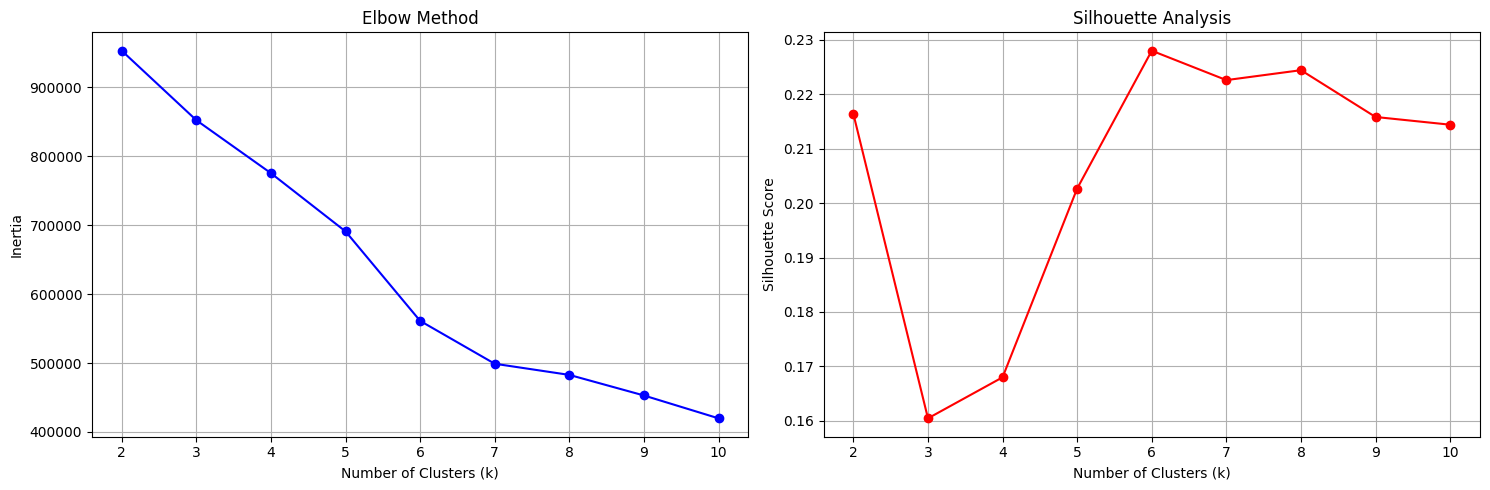

In [ ]:
k_range = range(2, 11)

plt.figure(figsize=(15, 5))

# Elbow plot
plt.subplot(1, 2, 1)
k_inert = [x[1] for x in inertias]
plt.plot(k_range, k_inert, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

# Silhouette plot
plt.subplot(1, 2, 2)
k_sil = [x[0] for x in silhouette_scores]
scores_sil = [x[1] for x in silhouette_scores]
plt.plot(k_sil, scores_sil, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)

plt.tight_layout()
plt.show()

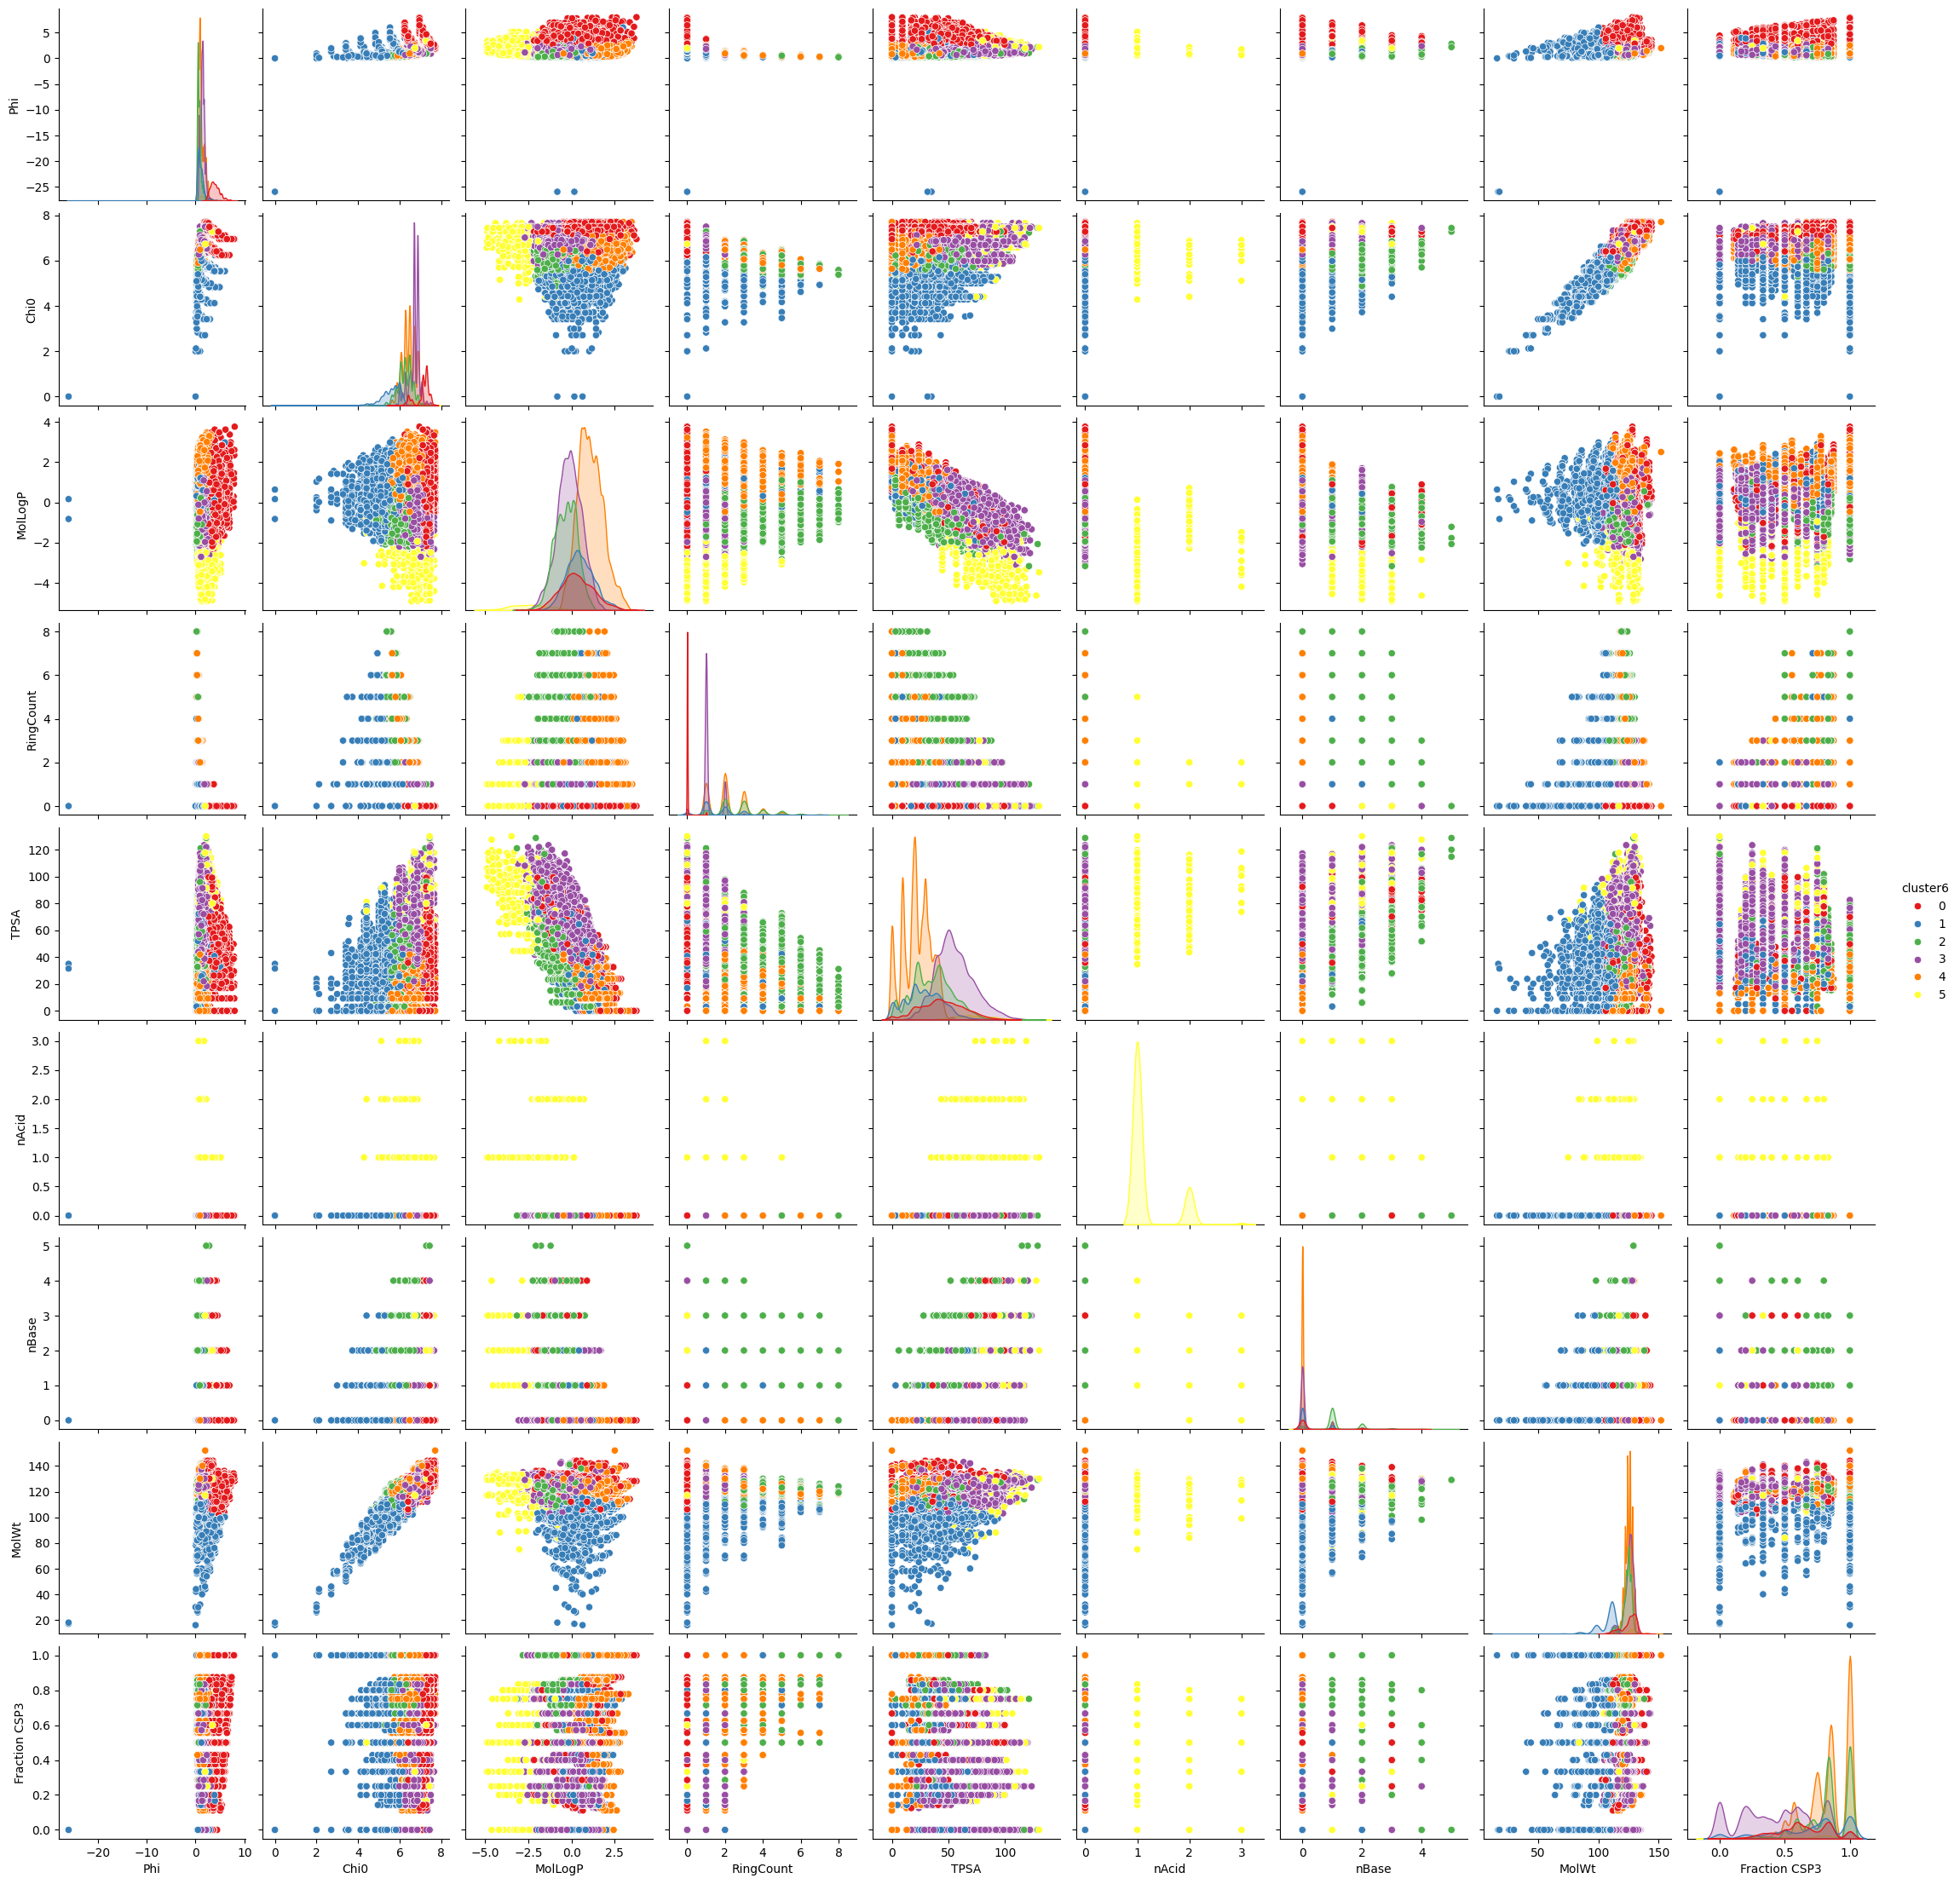

In [ ]:
sns.pairplot(df[['Phi', 'Chi0','MolLogP','RingCount', 'TPSA', 'nAcid', 'nBase', 'MolWt', 'Fraction CSP3', 'cluster'+str(best_n_clusters)]], 
             hue='cluster'+str(best_n_clusters), palette='Set1')  # or 'Set2', 'tab10', 'viridis', 'husl', etc.
# plt.show()

##### Silhouette analysis for best *k*

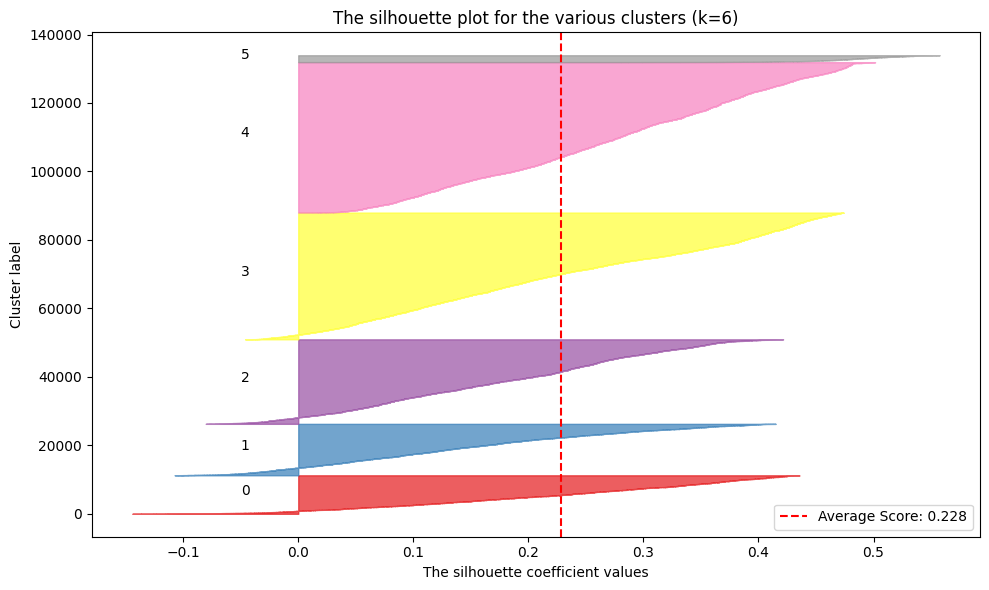

In [ ]:
from sklearn.metrics import silhouette_samples

def plot_silhouette_analysis(X, cluster_labels, n_clusters):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Calculate average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    y_lower = 10
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    
    for i in range(n_clusters):
        # Get silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = colors[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Update y_lower for next plot
        y_lower = y_upper + 10
    
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')
    ax.set_title(f'The silhouette plot for the various clusters (k={n_clusters})')
    
    # Add vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
               label=f'Average Score: {silhouette_avg:.3f}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Create the plot for your best number of clusters
plot_silhouette_analysis(feat_vector_scaled, df[f'k_{best_n_clusters}'], best_n_clusters)

### **HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise**

HDBSCAN can be seen as the modern successor to DBSCan and OPTICS. It takes the ideas from OPTICS and automates them. It transforms the space, builds a hierarchy of possible clusters, and then uses a stability metric to extract the most persistent clusters, effectively cutting the hierarchy tree at the most sensible locations.


Since the HDSCAN is a density based algorithm that can 

In [14]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score
min_cluster_size = [15, 25, 50, 75, 100, 250, 500]
hdbscan_results = []


for size in min_cluster_size:
    hdbscan = HDBSCAN(min_cluster_size=size, n_jobs=8)
    hdbscan_labels = hdbscan.fit_predict(feat_vector_scaled)
    
    df[f'hdbscan_{size}'] = hdbscan_labels

    n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
    n_noise = np.sum(hdbscan_labels == -1)
    n_total = len(hdbscan_labels)
    noise_percentage = (n_noise / n_total) * 100
    
    print(f"HDBSCAN with min_cluster_size={size}:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Noise points: {n_noise}/{n_total} ({noise_percentage:.1f}%)")
    
    # Calculate silhouette score excluding noise points
    if n_clusters > 1:
        # Create mask to exclude noise points (-1)
        non_noise_mask = hdbscan_labels != -1
        
        if np.sum(non_noise_mask) > 1:  # Need at least 2 non-noise points
            # Use only non-noise data points and their corresponding labels
            X_non_noise = feat_vector_scaled[non_noise_mask]
            labels_non_noise = hdbscan_labels[non_noise_mask]
            
            score = silhouette_score(X_non_noise, labels_non_noise)
            print(f"  Silhouette Score (excluding noise): {score:.3f}")
        else:
            score = -1
            print(f"  Not enough non-noise points for silhouette calculation")
    else:
        score = -1
        print(f"  Single cluster or only noise points - no silhouette score")
    
    # Store results for analysis
    hdbscan_results.append({
        'min_cluster_size': size,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percentage': noise_percentage,
        'silhouette_score': score
    })

HDBSCAN with min_cluster_size=15:
  Number of clusters: 3162
  Noise points: 35747/133885 (26.7%)
  Silhouette Score (excluding noise): 0.589
HDBSCAN with min_cluster_size=25:
  Number of clusters: 1503
  Noise points: 43028/133885 (32.1%)
  Silhouette Score (excluding noise): 0.506
HDBSCAN with min_cluster_size=50:
  Number of clusters: 484
  Noise points: 46641/133885 (34.8%)
  Silhouette Score (excluding noise): 0.323
HDBSCAN with min_cluster_size=75:
  Number of clusters: 244
  Noise points: 49252/133885 (36.8%)
  Silhouette Score (excluding noise): 0.230
HDBSCAN with min_cluster_size=100:
  Number of clusters: 125
  Noise points: 40866/133885 (30.5%)
  Silhouette Score (excluding noise): 0.117
HDBSCAN with min_cluster_size=250:
  Number of clusters: 3
  Noise points: 33/133885 (0.0%)
  Silhouette Score (excluding noise): 0.572
HDBSCAN with min_cluster_size=500:
  Number of clusters: 2
  Noise points: 370/133885 (0.3%)
  Silhouette Score (excluding noise): 0.572


In [15]:
hdbscan_df = pd.DataFrame(hdbscan_results)
print("\nHDBSCAN Results Summary:")
print(hdbscan_df.to_string(index=False))


HDBSCAN Results Summary:
 min_cluster_size  n_clusters  n_noise  noise_percentage  silhouette_score
               15        3162    35747         26.699780          0.588924
               25        1503    43028         32.138029          0.505901
               50         484    46641         34.836614          0.323188
               75         244    49252         36.786795          0.229601
              100         125    40866         30.523210          0.116606
              250           3       33          0.024648          0.571945
              500           2      370          0.276357          0.572084


By observing the above results, we can assume that the best HDBSCAN configuration is for *min_cluster_size=250* where the noise percentage is small and the silhouette score is high.

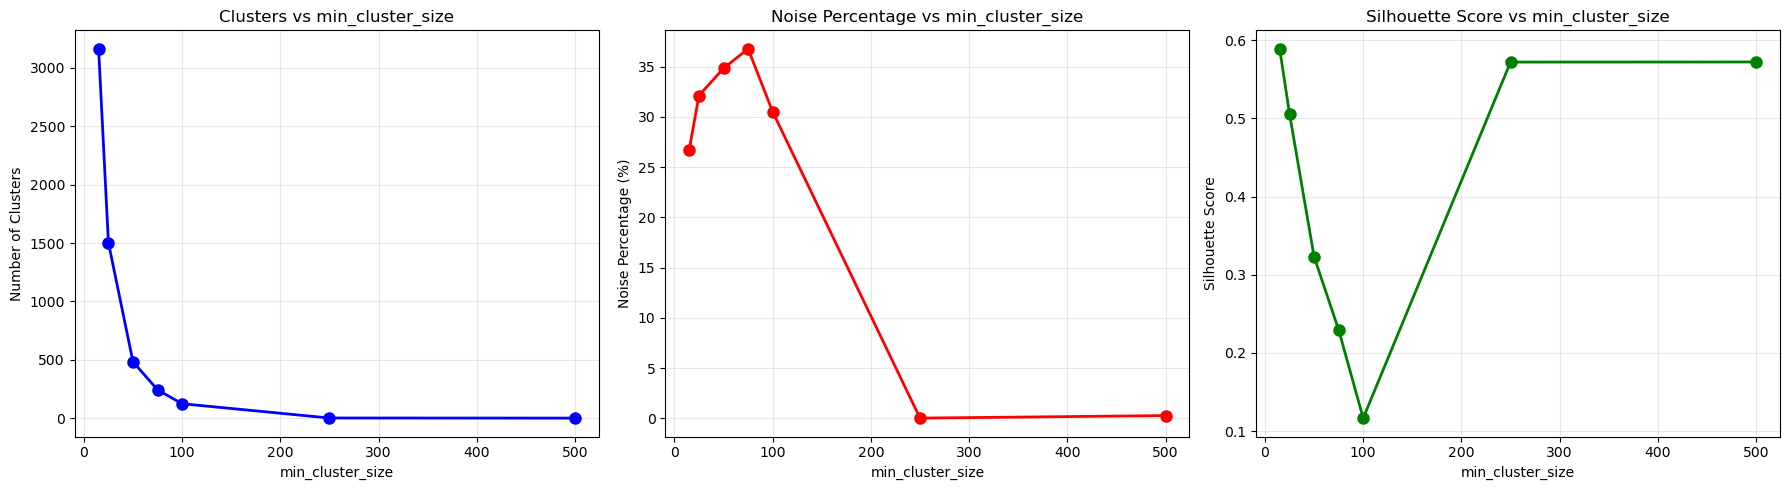


Best HDBSCAN configuration:
  min_cluster_size: 250.0
  Clusters: 3.0
  Noise: 0.0%
  Silhouette: 0.572


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Number of clusters vs min_cluster_size
axes[0].plot(hdbscan_df['min_cluster_size'], hdbscan_df['n_clusters'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('min_cluster_size')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('Clusters vs min_cluster_size')
axes[0].grid(True, alpha=0.3)

# Plot 2: Noise percentage vs min_cluster_size
axes[1].plot(hdbscan_df['min_cluster_size'], hdbscan_df['noise_percentage'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('min_cluster_size')
axes[1].set_ylabel('Noise Percentage (%)')
axes[1].set_title('Noise Percentage vs min_cluster_size')
axes[1].grid(True, alpha=0.3)

# Plot 3: Silhouette score vs min_cluster_size (only valid scores)
valid_scores = hdbscan_df[hdbscan_df['silhouette_score'] > -1]
if len(valid_scores) > 0:
    axes[2].plot(valid_scores['min_cluster_size'], valid_scores['silhouette_score'], 'go-', linewidth=2, markersize=8)
    axes[2].set_xlabel('min_cluster_size')
    axes[2].set_ylabel('Silhouette Score')
    axes[2].set_title('Silhouette Score vs min_cluster_size')
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'No valid silhouette scores', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Silhouette Score vs min_cluster_size')

plt.tight_layout()
plt.show()

# Find best HDBSCAN configuration
best_hdbscan = hdbscan_df[hdbscan_df['min_cluster_size'] == 250]
if len(best_hdbscan) > 0:
    best_idx = best_hdbscan['silhouette_score'].idxmax()
    best_config = hdbscan_df.loc[best_idx]
    print(f"\nBest HDBSCAN configuration:")
    print(f"  min_cluster_size: {best_config['min_cluster_size']}")
    print(f"  Clusters: {best_config['n_clusters']}")
    print(f"  Noise: {best_config['noise_percentage']:.1f}%")
    print(f"  Silhouette: {best_config['silhouette_score']:.3f}")
else:
    print("\nNo valid HDBSCAN configurations found")



#### Sillhouette and Cluster evaluation

Taking into account how the best *min_cluster_size=250* we can evaluate how well this algorithm is dividing our dataset.

For that, we will evaluate the sillhouete curve.

In [18]:
from sklearn.metrics import silhouette_samples

def plot_silhouette_analysis(X, cluster_labels, n_clusters):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Calculate average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    y_lower = 10
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    
    for i in range(n_clusters):
        # Get silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = colors[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Update y_lower for next plot
        y_lower = y_upper + 10
    
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')
    ax.set_title(f'The silhouette plot for the various clusters (k={n_clusters})')
    
    # Add vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
               label=f'Average Score: {silhouette_avg:.3f}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

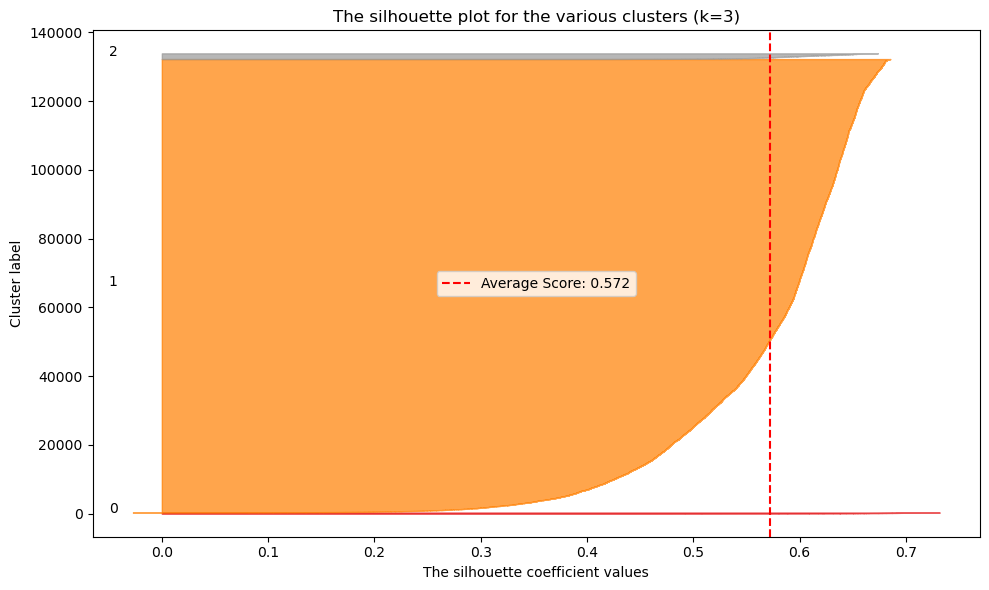

In [19]:
plot_silhouette_analysis(feat_vector_scaled, df[f'hdbscan_250'], 3)

In [ ]:
import hdbscan

hdbscan_model_for_tree = hdbscan.HDBSCAN(min_cluster_size=250, prediction_data=True)
hdbscan_model_for_tree.fit(feat_vector_scaled)

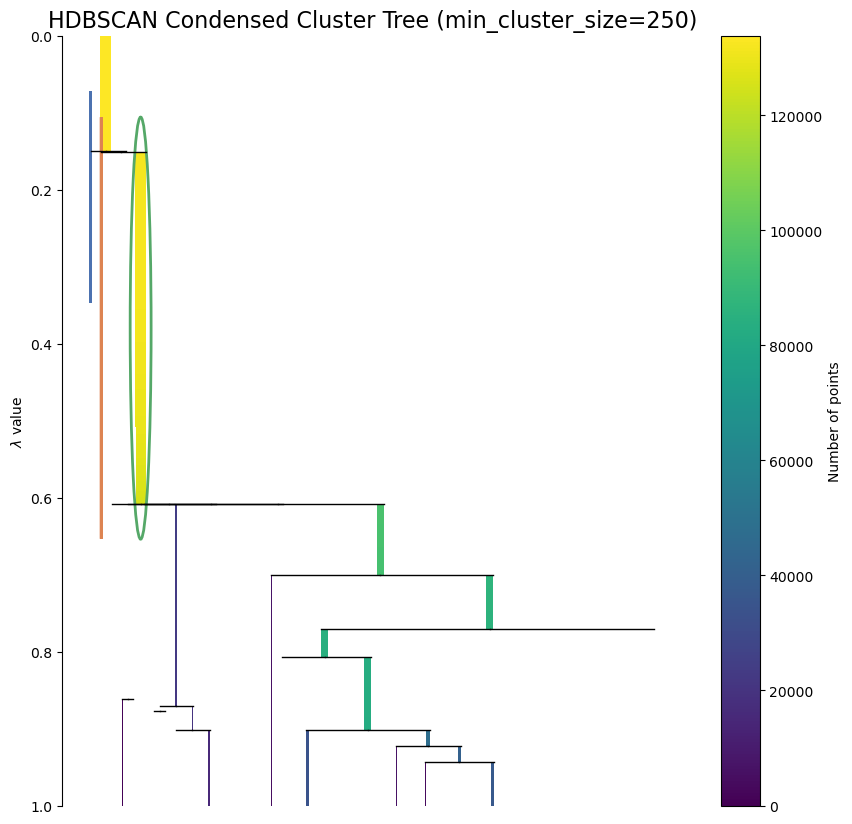

In [49]:
# Plotando a árvore de clusters condensada
plt.figure(figsize=(10, 10))
plt.title('HDBSCAN Condensed Cluster Tree (min_cluster_size=250)', fontsize=16)
ax = hdbscan_model_for_tree.condensed_tree_.plot(select_clusters=True,
                                                 selection_palette=sns.color_palette('deep'), 
                                                #  label_clusters=True,
                                                 colorbar=True)

# Set the y-axis (lambda) limit to show only values less than 3
ax.set_ylim(bottom=1)
plt.show()

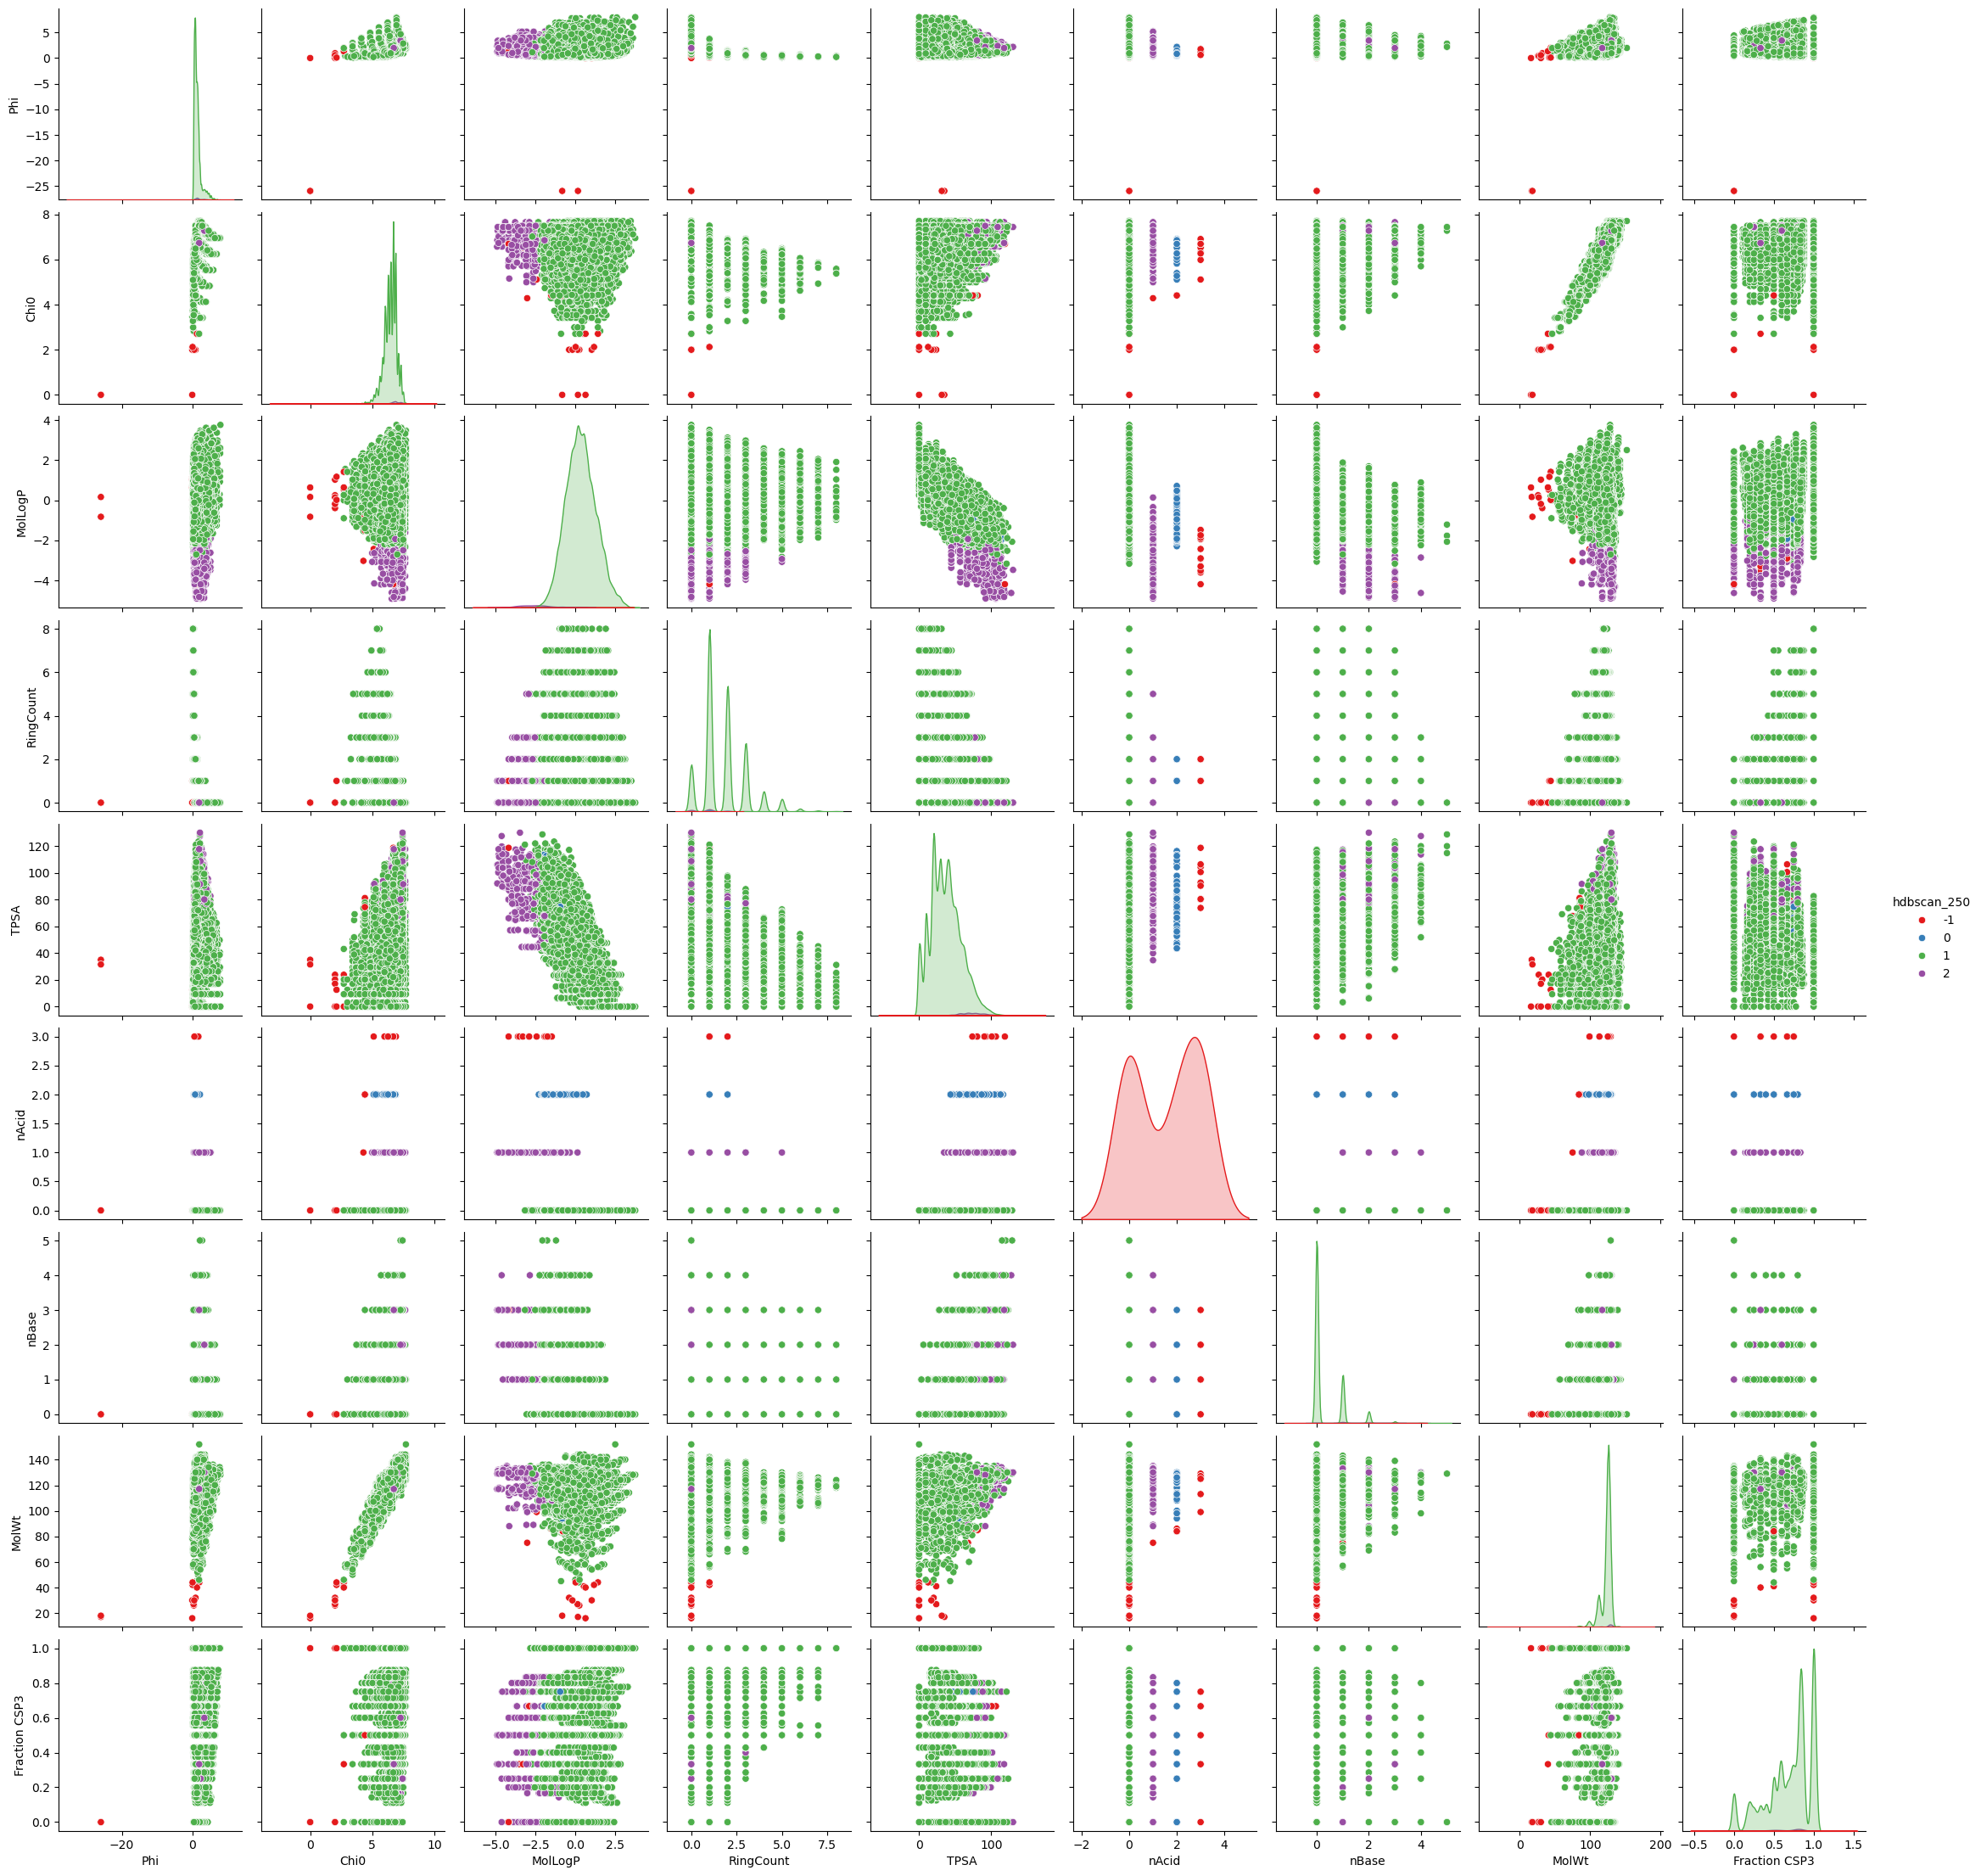

In [64]:
sns.pairplot(df[['Phi', 'Chi0','MolLogP','RingCount', 'TPSA', 'nAcid', 'nBase', 'MolWt', 'Fraction CSP3', 'hdbscan_250']], 
             hue='hdbscan_250', palette='Set1')  # or 'Set2', 'tab10', 'viridis', 'husl', etc.

In [52]:
df = pd.read_csv('datasets_csv/qm9_results.csv')

### PCA and properties evaluation

PCA Results:
Explained variance ratio: [0.32160139 0.20803585]
Total explained variance: 0.530

PCA Components (feature importance):
                    PC1       PC2
nBase          0.040850 -0.446406
nAcid          0.143369 -0.276977
RingCount     -0.450823 -0.247993
Chi0           0.461826  0.253808
MolLogP       -0.260099  0.573173
MolWt          0.260241  0.117074
TPSA           0.438196 -0.360539
Fraction CSP3 -0.302868  0.081396
Phi            0.377001  0.345310

CLUSTER ANALYSIS IN PCA SPACE

K-means Clusters:
Cluster 0: 11241 points
  PC1 mean: 2.462, std: 0.907
  PC2 mean: 1.569, std: 1.234
Cluster 1: 15019 points
  PC1 mean: -1.668, std: 1.307
  PC2 mean: -0.367, std: 0.994
Cluster 2: 24678 points
  PC1 mean: -0.747, std: 1.244
  PC2 mean: -1.398, std: 0.795
Cluster 3: 37013 points
  PC1 mean: 1.273, std: 0.782
  PC2 mean: -0.170, std: 0.793
Cluster 4: 43924 points
  PC1 mean: -0.879, std: 1.007
  PC2 mean: 0.852, std: 0.806
Cluster 5: 2010 points
  PC1 mean: 3.625, std: 1.27

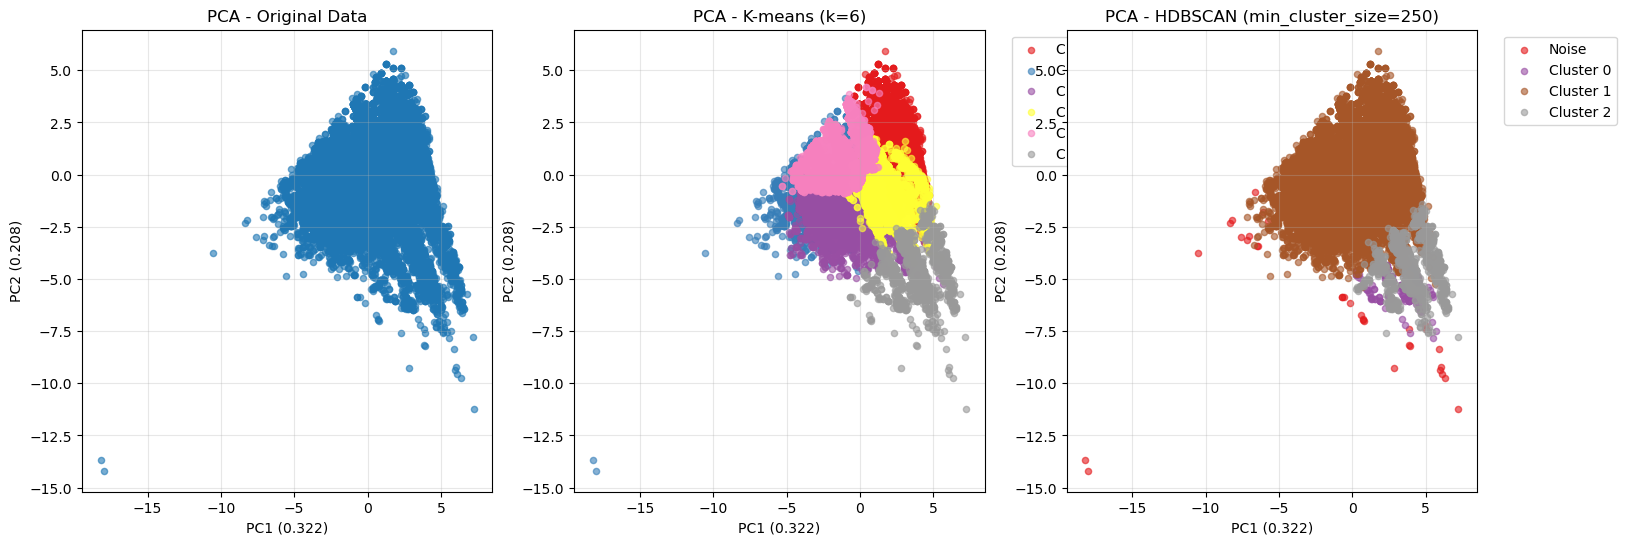

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
feat_vector_pca = pca.fit_transform(feat_vector_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(feat_vector_pca, columns=['PC1', 'PC2'])

# Add cluster labels to PCA DataFrame
pca_df['kmeans_best'] = df[f'k_{6}']
pca_df['hdbscan_250'] = df['hdbscan_250']

print("PCA Results:")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")
print("\nPCA Components (feature importance):")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=descriptors_list
)
print(components_df)

# Plot PCA results with different clustering methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original data (no clusters)
scatter1 = axes[0].scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
axes[0].set_title('PCA - Original Data')
axes[0].grid(True, alpha=0.3)

# K-means clusters
unique_kmeans = np.unique(pca_df['kmeans_best'])
colors_kmeans = plt.cm.Set1(np.linspace(0, 1, len(unique_kmeans)))
for i, cluster in enumerate(unique_kmeans):
    mask = pca_df['kmeans_best'] == cluster
    axes[1].scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                   c=[colors_kmeans[i]], label=f'Cluster {cluster}', alpha=0.6, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
axes[1].set_title(f'PCA - K-means (k={6})')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

# HDBSCAN clusters
unique_hdbscan = np.unique(pca_df['hdbscan_250'])
colors_hdbscan = plt.cm.Set1(np.linspace(0, 1, len(unique_hdbscan)))
for i, cluster in enumerate(unique_hdbscan):
    mask = pca_df['hdbscan_250'] == cluster
    label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    axes[2].scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                   c=[colors_hdbscan[i]], label=label, alpha=0.6, s=20)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
axes[2].set_title('PCA - HDBSCAN (min_cluster_size=250)')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
axes[2].grid(True, alpha=0.3)


# Print summary statistics for each cluster in PCA space
print("\n" + "="*60)
print("CLUSTER ANALYSIS IN PCA SPACE")
print("="*60)

print("\nK-means Clusters:")
for cluster in unique_kmeans:
    mask = pca_df['kmeans_best'] == cluster
    cluster_data = pca_df.loc[mask, ['PC1', 'PC2']]
    print(f"Cluster {cluster}: {len(cluster_data)} points")
    print(f"  PC1 mean: {cluster_data['PC1'].mean():.3f}, std: {cluster_data['PC1'].std():.3f}")
    print(f"  PC2 mean: {cluster_data['PC2'].mean():.3f}, std: {cluster_data['PC2'].std():.3f}")

print("\nHDBSCAN Clusters:")
for cluster in unique_hdbscan:
    mask = pca_df['hdbscan_250'] == cluster
    cluster_data = pca_df.loc[mask, ['PC1', 'PC2']]
    label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    print(f"{label}: {len(cluster_data)} points")
    print(f"  PC1 mean: {cluster_data['PC1'].mean():.3f}, std: {cluster_data['PC1'].std():.3f}")
    print(f"  PC2 mean: {cluster_data['PC2'].mean():.3f}, std: {cluster_data['PC2'].std():.3f}")

# Save PCA results to DataFrame for further analysis
df['PC1'] = pca_df['PC1']
df['PC2'] = pca_df['PC2']

print(f"\nPCA transformation completed. Results saved to df['PC1'] and df['PC2']")

Statistical Analysis of U0 for K-means (k=6)
       count        mean        std         min         25%         50%  \
k_6                                                                       
0    11241.0 -424.282735  40.540233 -621.434020 -455.145082 -424.183306   
1    15019.0 -353.883220  37.646518 -492.026657 -382.596221 -360.065318   
2    24678.0 -411.495409  26.063813 -585.422948 -435.265941 -404.296083   
3    37013.0 -440.629938  28.875754 -621.423548 -458.954844 -439.073371   
4    43924.0 -402.021565  28.866773 -714.568061 -423.029345 -401.940034   
5     2010.0 -444.237445  28.870208 -513.391151 -457.578825 -441.531298   

            75%         max  
k_6                          
0   -399.350842 -308.163476  
1   -329.083578  -40.478930  
2   -400.672482 -336.823026  
3   -419.223387 -340.294492  
4   -385.947257 -313.018955  
5   -435.182650 -284.372483  

Statistical Analysis of property for HDBSCAN (min_cluster_size=250)
                count        mean         std

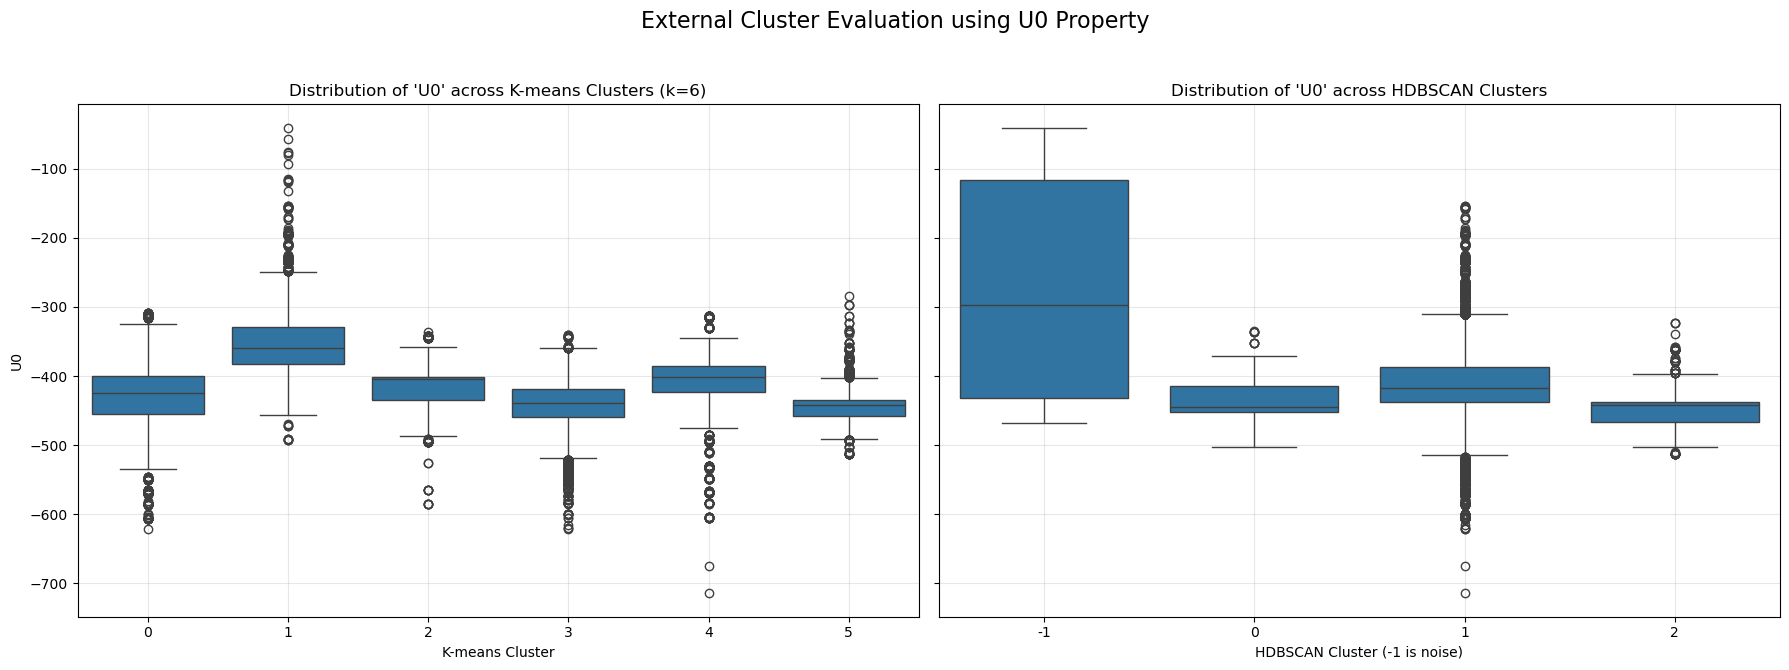

In [71]:
### III. External evaluation of the clusters using the property property
best_n_clusters = 6  # From previous K-means analysis
property = 'U0'
# Statistical analysis for K-means clusters
print("="*50)
print(f"Statistical Analysis of {property} for K-means (k={best_n_clusters})")
print("="*50)
kmeans_gap_stats = df.groupby(f'k_{best_n_clusters}')[property].describe()
print(kmeans_gap_stats)

# Statistical analysis for HDBSCAN clusters
print("\n" + "="*50)
print("Statistical Analysis of property for HDBSCAN (min_cluster_size=250)")
print("="*50)
hdbscan_gap_stats = df.groupby('hdbscan_250')[property].describe()
print(hdbscan_gap_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# K-means boxplot
sns.boxplot(ax=axes[0], x=f'k_{best_n_clusters}', y=property, data=df)
axes[0].set_title(f'Distribution of \'{property}\' across K-means Clusters (k={best_n_clusters})')
axes[0].set_xlabel('K-means Cluster')
axes[0].set_ylabel(property)
axes[0].grid(True, alpha=0.3)

# HDBSCAN boxplot
sns.boxplot(ax=axes[1], x='hdbscan_250', y=property, data=df)
axes[1].set_title(f'Distribution of \'{property}\' across HDBSCAN Clusters')
axes[1].set_xlabel('HDBSCAN Cluster (-1 is noise)')
axes[1].set_ylabel('')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"External Cluster Evaluation using {property} Property", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

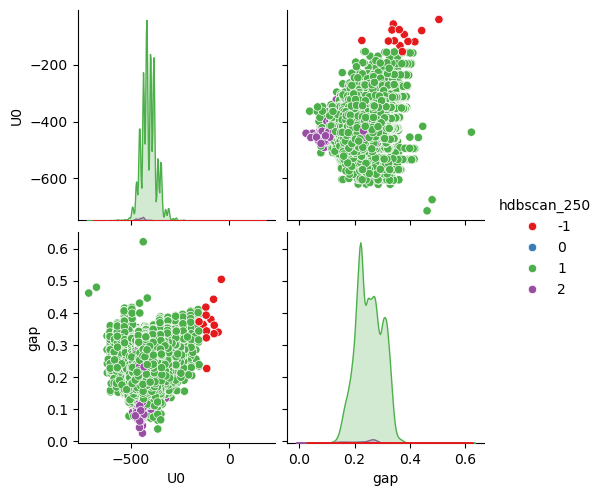

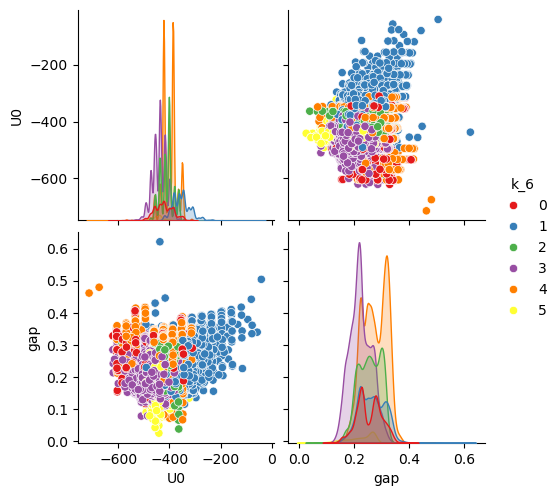

In [79]:
sns.pairplot(df[['U0', 'gap', 'hdbscan_250']], hue='hdbscan_250', palette='Set1')
sns.pairplot(df[['U0', 'gap', 'k_6']], hue='k_6', palette='Set1')